<a href="https://colab.research.google.com/github/zmalk/Amana-Bookstore/blob/main/Firstanalysis/language_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

try:
  from helper import FIG_DIR, PREFER_ORDER, COLOR_MAP
except Exception:
  FIG_DIR = Path("figs")
  FIG_DIR.mkdir(exist_ok=True)
  COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI_Codex": "#D55E00",
    "OpenAI Codex": "#D55E00",
    "Codex": "#F0E442",
    "Devin": "#009E73",
    "Copilot": "#0072B2",
    "GitHub Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude_Code": "#DC267F",
    "Claude Code": "#DC267F",
  }
  PREFER_ORDER = [
    "Human",
    "OpenAI_Codex",
    "Devin",
    "Copilot",
    "Cursor",
    "Claude_Code"
  ]

# Load Hugging Face datasets
repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/repository.parquet")
pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")

# –– Nature-ready styling
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times'],
    'mathtext.fontset': 'stix',
    'axes.linewidth': 1.0,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'figure.dpi': 300,
})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:



# %%
def list_agents(scope: bool = False) -> list[str]:
    """Return unique agent names from pr_df."""
    agents = sorted(pr_df["agent"].dropna().unique())
    return agents


def load_repo_meta(agent: str, scope: bool = False) -> pd.DataFrame:
    """
    Load repository metadata for one agent from in-memory DataFrames.
    Only returns repos that have PRs by this agent.
    """
    agent_prs = pr_df[pr_df["agent"] == agent]
    if agent_prs.empty:
        raise FileNotFoundError(f"No PRs found for agent {agent}")

    repo_subset = repo_df[repo_df["url"].isin(agent_prs["repo_url"])]
    return repo_subset


def language_counts(agent: str, scope: bool = False) -> pd.DataFrame:
    """Return repo-counts per language for a single agent."""
    df = load_repo_meta(agent, scope)
    counts = df["language"].value_counts(dropna=False).reset_index()
    counts.columns = ["language", "count"]
    return counts


def plot_language_usage(counts: pd.DataFrame, agent: str, scope: bool = False) -> None:
    """Bar-plot language frequencies for one agent."""
    if counts.empty:
        print(f"No language data for {agent}")
        return
    plt.figure(figsize=(6, 4))
    sns.barplot(x="language", y="count", data=counts, color="tab:blue")
    plt.xlabel("Language")
    plt.ylabel("Repository Count")
    title = f"{agent} repo languages" + (" (scope)" if scope else "")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    FIG_DIR.mkdir(exist_ok=True, parents=True)
    suffix = "_scope" if scope else ""
    out = FIG_DIR / f"{agent}_languages{suffix}.png"
    plt.savefig(out)
    plt.close()
    print("Wrote", out)


def process_agent(agent: str, scope: bool = False) -> None:
    """Create per-agent CSV and bar-plot."""
    try:
        counts = language_counts(agent, scope)
    except FileNotFoundError as e:
        print(e)
        return

    out_fp = FIG_DIR / f"{agent}_languages.csv"
    counts.to_csv(out_fp, index=False)
    print("Wrote", out_fp)
    plot_language_usage(counts, agent, scope)


# %%
TOP_N = 10


def _collect_stats(agents: list[str], scope: bool):
    count_frames = []
    all_repos = []

    for agent in agents:
        df = load_repo_meta(agent, scope)[["url", "language"]]
        df = df.drop_duplicates(subset="url")
        df["agent"] = agent
        all_repos.append(df)
        print(f"Processing {agent} with {len(df)} repositories, {df['language'].isna().sum()} missing languages")

        counts = df["language"].value_counts(dropna=False)
        count_frames.append(counts.rename(agent))

    count_df = pd.concat(count_frames, axis=1).T.fillna(0).astype(int)
    pct_df = (count_df.T / count_df.sum(axis=1)).T * 100
    pct_df = pct_df.round(1)

    combined_df = pd.concat(all_repos).drop_duplicates(subset="url")
    dedup_totals = combined_df["language"].value_counts(dropna=False).sort_values(ascending=False).astype(int)

    return count_df, pct_df, dedup_totals


def _build_summary_table(count_df: pd.DataFrame, pct_df: pd.DataFrame, totals: pd.Series) -> pd.DataFrame:
    agents = [a for a in PREFER_ORDER if a != "Human" and a in count_df.index]
    top_langs = totals.index
    count_slice = count_df.loc[agents, top_langs].T
    pct_slice = pct_df.loc[agents, top_langs].T

    total_repos = totals.sum()
    overall_pct = (totals / total_repos * 100).round(1)
    overall_count = totals.loc[top_langs]

    total_data = pd.concat([overall_count, overall_pct], axis=1)
    total_data.columns = [("Total", "#"), ("Total", "%")]

    cols, data_parts = [], []
    for agent in agents:
        cols.extend([(agent, "#"), (agent, "%")])
        data_parts.append(count_slice[agent])
        data_parts.append(pct_slice[agent])

    agent_data = pd.concat(data_parts, axis=1)
    agent_data.columns = pd.MultiIndex.from_tuples(cols)

    table = pd.concat([total_data, agent_data], axis=1)
    table.index.name = "Language"
    table = table.loc[top_langs]

    int_cols = [col for col in table.columns if col[1] == "#"]
    table[int_cols] = table[int_cols].astype(int)
    return table


def _latex(table: pd.DataFrame) -> str:
    n_agents = len(table.columns) // 2
    col_fmt = "l" + "r" * (2 * n_agents)
    return table.to_latex(
        float_format="{:.1f}".format,
        column_format=col_fmt,
        multicolumn=True,
        multicolumn_format="c",
        caption=f"Top-{TOP_N} languages across agents: per-agent rank and percentage.",
        label="tab:language-usage",
        na_rep=""
    )


def run_summary(scope: bool = False):
    agents = [a for a in list_agents(scope) if a != "Human"]
    if not agents:
        print("No non-human agents found")
        return
    count_df, pct_df, totals = _collect_stats(agents, scope)
    table = _build_summary_table(count_df, pct_df, totals)
    print(_latex(table))
    return count_df, pct_df, totals

In [ ]:

count_df, pct_df, totals = run_summary(scope=True)

Processing Claude_Code with 213 repositories, 2 missing languages
Processing Copilot with 1012 repositories, 18 missing languages
Processing Cursor with 327 repositories, 2 missing languages
Processing Devin with 288 repositories, 1 missing languages
Processing OpenAI_Codex with 1248 repositories, 14 missing languages
\begin{table}
\caption{Top-10 languages across agents: per-agent rank and percentage.}
\label{tab:language-usage}
\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & ('Total', '#') & ('Total', '%') & ('OpenAI_Codex', '#') & ('OpenAI_Codex', '%') & ('Devin', '#') & ('Devin', '%') & ('Copilot', '#') & ('Copilot', '%') & ('Cursor', '#') & ('Cursor', '%') & ('Claude_Code', '#') & ('Claude_Code', '%') \\
language &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
TypeScript & 650 & 23.2 & 247 & 19.8 & 137 & 47.6 & 196 & 19.4 & 136 & 41.6 & 57 & 26.8 \\
Python & 530 & 18.9 & 304 & 24.4 & 51 & 17.7 & 132 & 13.0 & 57 & 17.4 & 53 & 24.9 \\
Go & 242 & 8.6 & 110 & 8.8 & 20 & 6.9 & 88 & 8.7 & 22

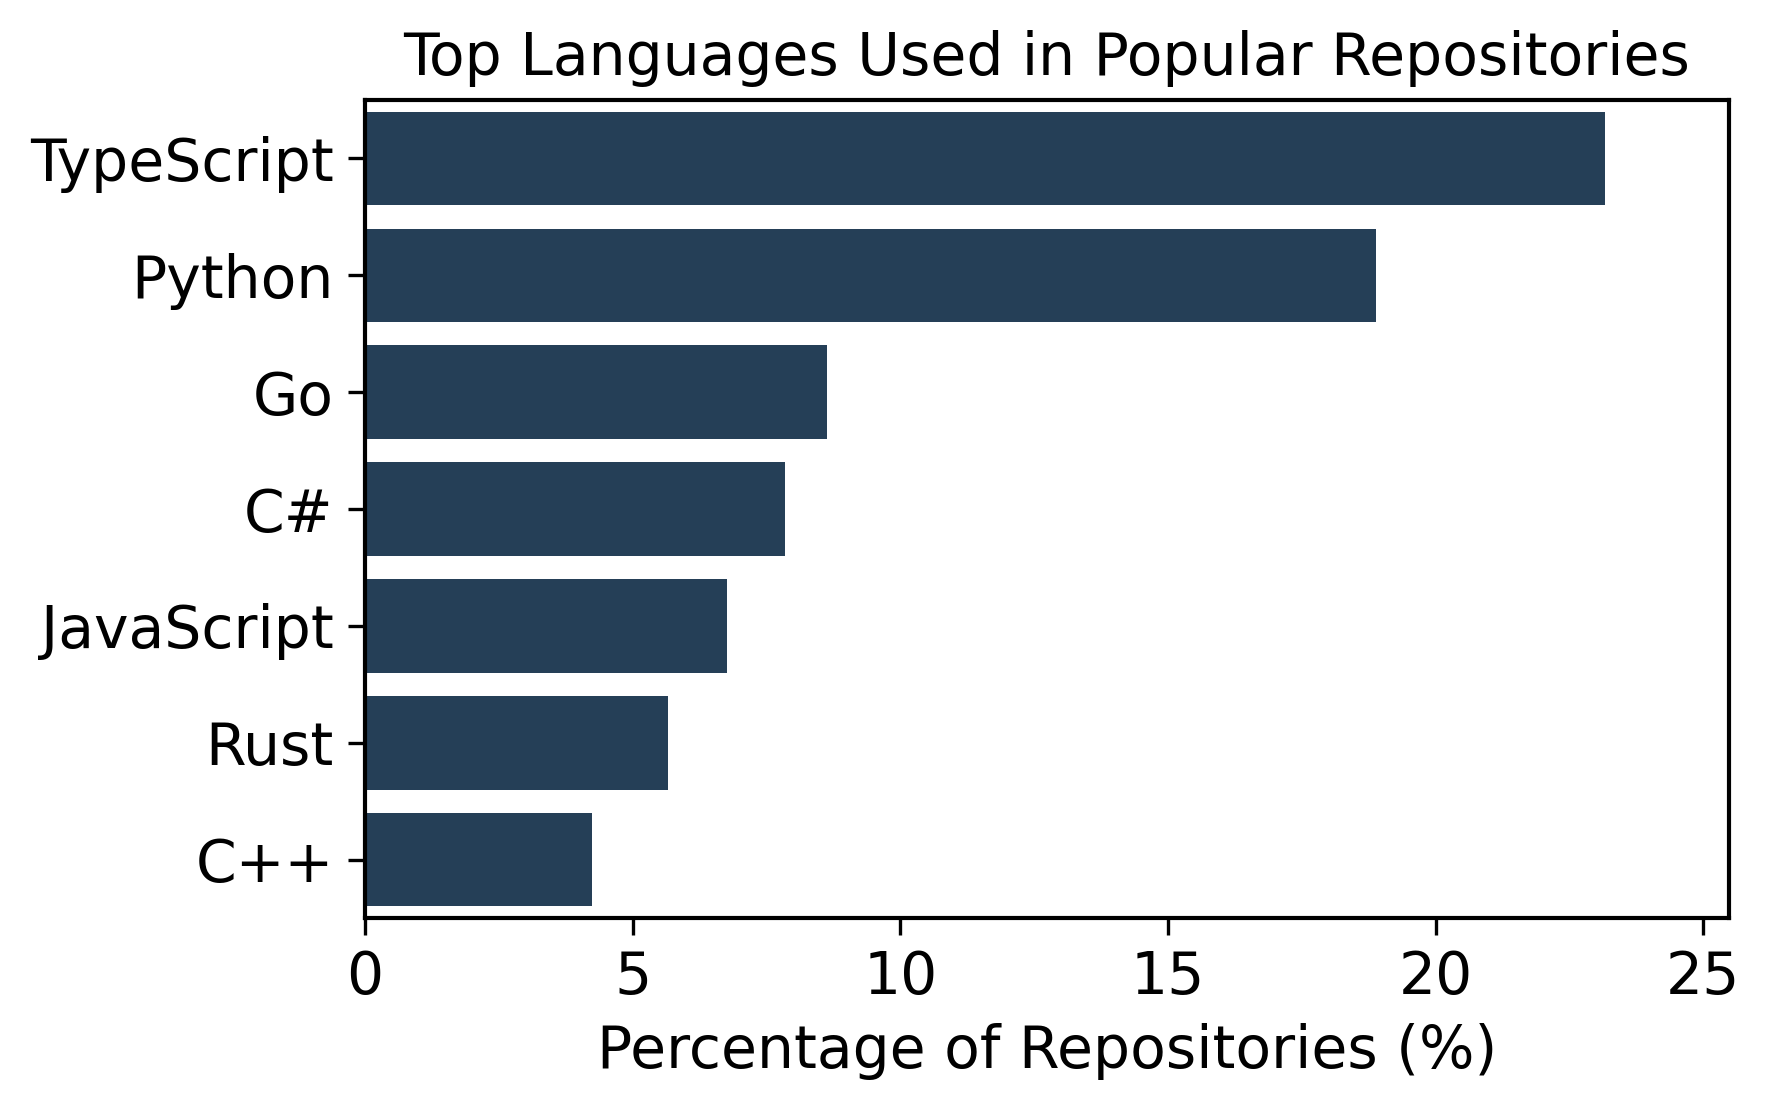

Wrote figs/total_language_percentages_top.png


In [ ]:


# %%
def plot_total_language_percentages(totals: pd.Series, top_n: int = TOP_N, scope: bool = False) -> None:
    if totals.empty:
        print("No language totals to plot.")
        return
    pct = (totals / totals.sum() * 100).sort_values(ascending=False)
    if top_n:
        pct = pct.head(top_n)

    plt.figure(figsize=(6, 0.4 * len(pct) + 1))
    sns.barplot(y=pct.index, x=pct.values, orient="h", color="#1C3F60")
    plt.grid(False)
    plt.xlabel("Percentage of Repositories (%)")
    plt.ylabel(None)
    plt.title("Top Languages Used in Popular Repositories")
    plt.xlim(0, pct.max() * 1.10)
    plt.tight_layout()

    FIG_DIR.mkdir(parents=True, exist_ok=True)
    out = FIG_DIR / f"total_language_percentages_top.png"
    plt.savefig(out)
    plt.show()
    plt.close()
    print("Wrote", out)


# %%
plot_total_language_percentages(totals, top_n=7)


In [1]:
# =============================================================================
# FIXED REVIEW ASPECTS ANALYSIS
# Fixes: 1) Inline comments, 2) Human PRs, 3) Improved Keywords
# =============================================================================

from __future__ import annotations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION
# =============================================================================
FIG_DIR = Path("figs/review_aspects_fixed")
FIG_DIR.mkdir(exist_ok=True, parents=True)

# Hugging Face paths
HF_PR_PATH = "hf://datasets/hao-li/AIDev/pull_request.parquet"
HF_REPO_PATH = "hf://datasets/hao-li/AIDev/repository.parquet"
HF_HUMAN_PR_PATH = "hf://datasets/hao-li/AIDev/human_pull_request.parquet"

# Review data paths - NOTE: Using v2 for review comments!
HF_PR_COMMENTS = "hf://datasets/hao-li/AIDev/pr_comments.parquet"
HF_PR_REVIEW_COMMENTS_V2 = "hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet"  # FIXED!
HF_PR_REVIEWS = "hf://datasets/hao-li/AIDev/pr_reviews.parquet"

# Color mapping
COLOR_MAP = {
    "Human": "#56B4E9",
    "OpenAI Codex": "#D55E00",
    "Devin": "#009E73",
    "GitHub Copilot": "#0072B2",
    "Cursor": "#785EF0",
    "Claude Code": "#DC267F",
}

NAME_MAPPING = {
    "OpenAI_Codex": "OpenAI Codex",
    "Copilot": "GitHub Copilot",
    "Claude_Code": "Claude Code",
    "Human": "Human",
}

# =============================================================================
# IMPROVED ASPECT KEYWORDS (Reduced "Other" category)
# =============================================================================
ASPECT_KEYWORDS = {
    'correctness': [
        # Core bugs/errors
        r'\bbug\b', r'\berror\b', r'\bwrong\b', r'\bincorrect\b', r'\bfail',
        r'\bfix\b', r'\bissue\b', r'\bproblem\b', r'\bbroken\b', r'\bcrash',
        r'\bexception\b', r'\bdefect\b', r'\bflaw\b', r'\blogic.*error',
        r'\bnot\s+work', r'\bdoesn\'?t\s+work', r'\bshould\s+be\b',
        r'\bmistake\b', r'\binvalid\b', r'\bbreaks\b',
        # Additional correctness patterns
        r'\btypo\b', r'\bregression\b', r'\bnull\b', r'\bundefined\b',
        r'\boutofbound', r'\boverflow\b', r'\bunderflow\b', r'\brace\s+condition',
        r'\bdeadlock\b', r'\binfinite\s+loop', r'\boff.by.one', r'\bwon\'?t\s+compile',
        r'\bsyntax\s+error', r'\btype\s+error', r'\bmissing\b', r'\bforgot',
        r'\bincomplete\b', r'\bwrongly\b', r'\bincorrectly\b',
    ],
    'style': [
        # Formatting & conventions
        r'\bformat', r'\bstyle\b', r'\bindent', r'\bwhitespace\b', r'\bnaming\b',
        r'\breadab', r'\bclean', r'\bconsistent', r'\bconvention\b', r'\blint',
        r'\bpep\s*8', r'\bprettier\b', r'\beslint\b', r'\bcode\s+style',
        r'\bformatting\b', r'\bspacing\b', r'\brefactor',
        # Additional style patterns
        r'\bcamel\s*case', r'\bsnake\s*case', r'\bpascal\s*case',
        r'\btabs?\b', r'\bspaces\b', r'\btrailing\b', r'\bnewline',
        r'\bbraces?\b', r'\bparenthes', r'\bquotes?\b', r'\bsemicolon',
        r'\borganiz', r'\bstructure\b', r'\bmodular', r'\bDRY\b',
        r'\bSOLID\b', r'\bcleanup\b', r'\btidy\b', r'\bnit\b', r'\bnitpick',
    ],
    'security': [
        # Core security
        r'\bsecur', r'\bvulner', r'\bauthen', r'\bauthoriz', r'\bsanitiz',
        r'\binjection', r'\bxss\b', r'\bcsrf\b', r'\bsql.*inject',
        r'\bpassword', r'\btoken\b', r'\bencrypt', r'\bprivacy\b', r'\bleak',
        r'\bpermission', r'\baccess\s+control', r'\bexploit',
        # Additional security patterns
        r'\bcredential', r'\bsecret\b', r'\bapi\s*key', r'\bhash',
        r'\bsalt\b', r'\bcrypto', r'\bssl\b', r'\btls\b', r'\bhttps',
        r'\bcors\b', r'\bsanitize', r'\bescape\b', r'\bvalidat',
        r'\btrust', r'\bunsafe\b', r'\bdangerous', r'\bmalicious',
        r'\bprivileg', r'\brole\b', r'\bacl\b', r'\boauth', r'\bjwt\b',
    ],
    'testing': [
        # Core testing
        r'\btest\b', r'\btests\b', r'\bcoverage\b', r'\bunit\s+test', r'\bintegration\s+test',
        r'\be2e\b', r'\bmock\b', r'\bassertion', r'\bedge\s+case',
        r'\btest\s+case', r'\bci\b', r'\bfailing\s+test', r'\bshould\s+test',
        r'\btest\s+suite',
        # Additional testing patterns
        r'\bspec\b', r'\bspecs\b', r'\bdescribe\b', r'\bit\s*\(', r'\bexpect\b',
        r'\bassert\b', r'\bverify\b', r'\bvalidat.*test', r'\bfixture',
        r'\bstub\b', r'\bspy\b', r'\btdd\b', r'\bbdd\b', r'\bpytest',
        r'\bjest\b', r'\bmocha\b', r'\bjunit\b', r'\brspec\b', r'\bselenium',
        r'\bcypress\b', r'\bplaywright\b', r'\btestcase\b', r'\btested\b',
    ],
    'performance': [
        # Core performance
        r'\bperformance\b', r'\boptimiz', r'\bslow\b', r'\bfast', r'\beffic',
        r'\bmemory\b', r'\bcpu\b', r'\bscale', r'\btimeout\b', r'\bcache',
        r'\blatency\b', r'\bthroughput\b', r'\bbottleneck', r'\bO\([nN]\)',
        r'\bspeed\b',
        # Additional performance patterns
        r'\bbenchmark', r'\bprofile', r'\blaszy\b', r'\beager\b',
        r'\basync', r'\bparallel', r'\bconcurren', r'\bthread',
        r'\bqueue\b', r'\bbatch', r'\bbulk\b', r'\bpagina', r'\bindex',
        r'\bquery\s+optim', r'\bn\+1\b', r'\btime\s+complex', r'\bspace\s+complex',
        r'\bheap\b', r'\bstack\b', r'\bgc\b', r'\bgarbage\b', r'\balloc',
    ],
    'documentation': [
        # Core documentation
        r'\bdoc\b', r'\bdocs\b', r'\bcomment\b', r'\bexplain', r'\bdocstring', r'\breadme',
        r'\bjavadoc\b', r'\bjsdoc\b', r'\bannotation', r'\bdescri', r'\bclarif',
        r'\bdocumentation', r'\badd\s+comment', r'\bunclear',
        # Additional documentation patterns
        r'\bapi\s+doc', r'\bchangelog', r'\brelease\s+note', r'\btutorial',
        r'\bexample', r'\bsample', r'\bguide\b', r'\bhow\s+to', r'\bwhy\b',
        r'\bwhat\s+does', r'\bpurpose\b', r'\breason\b', r'\bintent',
        r'\btype\s*hint', r'\bannotat', r'\b@param\b', r'\b@return',
        r'\bspecif', r'\bverbose\b', r'\bself.explain', r'\breadability',
    ],
    'architecture': [  # NEW CATEGORY
        r'\barchitect', r'\bdesign\b', r'\bpattern\b', r'\babstract',
        r'\binterface\b', r'\bcontract\b', r'\bdecouple', r'\bcouple',
        r'\bdependenc', r'\binject', r'\bfactory\b', r'\bsingleton',
        r'\bobserver\b', r'\bstrategy\b', r'\bfacade\b', r'\badapter',
        r'\bmodule\b', r'\bcomponent', r'\blayer\b', r'\btier\b',
        r'\bmicroservice', r'\bmonolith', r'\bapi\s+design', r'\brest\b',
        r'\bgraphql\b', r'\bschema\b', r'\bmodel\b', r'\bentity\b',
    ],
    'error_handling': [  # NEW CATEGORY
        r'\berror\s+handl', r'\bexception\s+handl', r'\btry\b', r'\bcatch\b',
        r'\bfinally\b', r'\bthrow\b', r'\braise\b', r'\brescue\b',
        r'\bfallback\b', r'\bretry\b', r'\bgraceful', r'\bfail\s*safe',
        r'\bfail\s*over', r'\brecover', r'\brollback', r'\btransaction',
        r'\berror\s+message', r'\bstack\s*trace', r'\blog.*error',
        r'\bhandle\s+error', r'\bcheck.*null', r'\bnull\s*check',
    ],
    'maintainability': [  # NEW CATEGORY
        r'\bmaintain', r'\breadable\b', r'\bunderstand', r'\bcomplex',
        r'\bsimpl', r'\bclarity\b', r'\bconfus', r'\bhard\s+to\s+read',
        r'\bmagic\s+number', r'\bhardcode', r'\bconstant\b', r'\bconfig',
        r'\bextensib', r'\bflexi', r'\breusab', r'\bgeneric\b',
        r'\bspecializ', r'\bcouple\b', r'\bcohes', r'\bencapsul',
        r'\bmodular', r'\bdecompos', r'\bseparate\s+concern',
    ],
}

print("✅ Configuration loaded!")
print(f"📁 Output directory: {FIG_DIR.absolute()}")
print(f"📊 Aspect categories: {len(ASPECT_KEYWORDS)}")

# =============================================================================
# DATA LOADING (FIXED)
# =============================================================================

def load_data(stars_threshold: int = 500):
    """Load all data with fixes for inline comments and Human PRs."""
    print("\n" + "="*80)
    print("📦 LOADING AIDEV DATASET (FIXED VERSION)")
    print("="*80)

    # Load PRs
    print("\n⏳ Loading AI PRs...")
    pr_ai = pd.read_parquet(HF_PR_PATH)
    pr_ai['source'] = 'AI'

    print("⏳ Loading Human PRs...")
    pr_human = pd.read_parquet(HF_HUMAN_PR_PATH)
    pr_human['source'] = 'Human'
    pr_human['agent'] = 'Human'  # Add agent column for Human PRs

    # Load repositories for star filtering
    print("⏳ Loading repositories...")
    repo_df = pd.read_parquet(HF_REPO_PATH)

    # Filter by stars
    print(f"🔍 Filtering repos with {stars_threshold}+ stars...")
    good_repos = repo_df[repo_df['stars'] >= stars_threshold]['url'].astype(str).unique()
    good_repo_urls = set(good_repos)

    pr_ai = pr_ai[pr_ai['repo_url'].astype(str).isin(good_repo_urls)].copy()
    pr_human = pr_human[pr_human['repo_url'].astype(str).isin(good_repo_urls)].copy()

    print(f"  ✓ AI PRs after filtering: {len(pr_ai):,}")
    print(f"  ✓ Human PRs after filtering: {len(pr_human):,}")

    # Combine
    pr_all = pd.concat([pr_ai, pr_human], ignore_index=True)

    return pr_all, repo_df


def load_review_comments_fixed(pr_df: pd.DataFrame):
    """Load review comments with FIXED pr_id extraction."""
    print("\n" + "="*80)
    print("💬 LOADING REVIEW COMMENTS (FIXED)")
    print("="*80)

    pr_ids = set(pr_df['id'].unique())
    print(f"🎯 Target PRs: {len(pr_ids):,}")

    # 1. Load discussion comments (pr_comments)
    print("\n1️⃣ Loading discussion comments...")
    pr_comments = pd.read_parquet(HF_PR_COMMENTS)
    pr_comments_filtered = pr_comments[pr_comments['pr_id'].isin(pr_ids)].copy()
    pr_comments_filtered['comment_type'] = 'discussion'
    print(f"   ✓ {len(pr_comments_filtered):,} discussion comments")

    # 2. Load inline review comments (V2 - with pr_id!)
    print("\n2️⃣ Loading inline review comments (V2)...")
    try:
        pr_review_comments = pd.read_parquet(HF_PR_REVIEW_COMMENTS_V2)
        print(f"   Columns: {pr_review_comments.columns.tolist()}")

        # Check if pr_id exists
        if 'pr_id' in pr_review_comments.columns:
            pr_review_comments_filtered = pr_review_comments[
                pr_review_comments['pr_id'].isin(pr_ids)
            ].copy()
        elif 'pull_request_url' in pr_review_comments.columns:
            # Extract pr_id from URL
            print("   ⚠️ Extracting pr_id from pull_request_url...")

            # Create mapping from PR URL to PR ID
            pr_df_for_mapping = pr_df[['id', 'html_url']].dropna()
            url_to_id = dict(zip(
                pr_df_for_mapping['html_url'].astype(str),
                pr_df_for_mapping['id']
            ))

            # Also try API URL format
            if 'repo_url' in pr_df.columns:
                for _, row in pr_df[['id', 'repo_url', 'number']].dropna().iterrows():
                    api_url = f"{row['repo_url']}/pulls/{int(row['number'])}"
                    url_to_id[api_url] = row['id']

            pr_review_comments['pr_id'] = pr_review_comments['pull_request_url'].map(url_to_id)
            pr_review_comments_filtered = pr_review_comments[
                pr_review_comments['pr_id'].isin(pr_ids)
            ].copy()
        else:
            print("   ❌ Cannot find pr_id column!")
            pr_review_comments_filtered = pd.DataFrame()

        pr_review_comments_filtered['comment_type'] = 'inline_review'
        print(f"   ✓ {len(pr_review_comments_filtered):,} inline review comments")

    except Exception as e:
        print(f"   ❌ Error loading inline comments: {e}")
        pr_review_comments_filtered = pd.DataFrame()

    # 3. Load review verdicts (pr_reviews)
    print("\n3️⃣ Loading review verdicts...")
    pr_reviews = pd.read_parquet(HF_PR_REVIEWS)
    pr_reviews_filtered = pr_reviews[pr_reviews['pr_id'].isin(pr_ids)].copy()
    pr_reviews_filtered['comment_type'] = 'review_verdict'
    print(f"   ✓ {len(pr_reviews_filtered):,} review verdicts")

    # Combine all comments
    all_comments = []

    for df, name in [
        (pr_comments_filtered, 'discussion'),
        (pr_review_comments_filtered, 'inline_review'),
        (pr_reviews_filtered, 'review_verdict')
    ]:
        if not df.empty and 'body' in df.columns:
            subset = df[['pr_id', 'body', 'comment_type']].copy()
            all_comments.append(subset)
            print(f"   ✓ Added {len(subset):,} {name} comments")

    if not all_comments:
        raise ValueError("No comments found!")

    comments_df = pd.concat(all_comments, ignore_index=True)

    # Remove empty comments
    comments_df = comments_df[comments_df['body'].notna()]
    comments_df = comments_df[comments_df['body'].str.strip() != '']

    print(f"\n{'='*80}")
    print(f"✓ TOTAL COMMENTS: {len(comments_df):,}")

    return comments_df


def add_pr_metadata(comments_df: pd.DataFrame, pr_df: pd.DataFrame):
    """Add agent and source information to comments."""
    print("\n⏳ Adding PR metadata...")

    pr_info = pr_df[['id', 'agent', 'source']].drop_duplicates()

    comments_with_meta = comments_df.merge(
        pr_info,
        left_on='pr_id',
        right_on='id',
        how='left'
    )

    # Drop rows without agent info
    comments_with_meta = comments_with_meta[comments_with_meta['agent'].notna()]

    print(f"\n📊 Comments by Source:")
    print(comments_with_meta['source'].value_counts().to_string())

    print(f"\n📊 Comments by Agent:")
    print(comments_with_meta['agent'].value_counts().to_string())

    return comments_with_meta


# =============================================================================
# ASPECT CATEGORIZATION (IMPROVED)
# =============================================================================

def categorize_comment(text: str) -> list[str]:
    """Categorize a comment into aspects."""
    if pd.isna(text) or not text.strip():
        return ['other']

    text_lower = text.lower()
    matched = []

    for aspect, patterns in ASPECT_KEYWORDS.items():
        for pattern in patterns:
            if re.search(pattern, text_lower):
                matched.append(aspect)
                break

    return matched if matched else ['other']


def categorize_all_comments(comments_df: pd.DataFrame):
    """Apply categorization to all comments."""
    print("\n" + "="*80)
    print("🏷️  CATEGORIZING COMMENTS (IMPROVED KEYWORDS)")
    print("="*80)

    comments_df = comments_df.copy()
    comments_df['aspects'] = comments_df['body'].apply(categorize_comment)

    # Explode to one row per aspect
    comments_exploded = comments_df.explode('aspects')
    comments_exploded = comments_exploded[comments_exploded['aspects'].notna()]

    # Show distribution
    aspect_counts = comments_exploded['aspects'].value_counts()
    total = len(comments_exploded)

    print(f"\n{'='*80}")
    print("📊 ASPECT DISTRIBUTION")
    print(f"{'='*80}")

    for aspect, count in aspect_counts.items():
        pct = (count / total) * 100
        bar = '█' * int(pct / 2)
        print(f"  {aspect.capitalize():18s}: {count:6,} ({pct:5.1f}%) {bar}")

    # Calculate "Other" percentage
    other_count = aspect_counts.get('other', 0)
    other_pct = (other_count / total) * 100
    print(f"\n📈 'Other' category: {other_pct:.1f}% (Target: < 15%)")

    return comments_exploded


# =============================================================================
# STATISTICAL ANALYSIS
# =============================================================================

def analyze_by_source(comments_df: pd.DataFrame):
    """Compare AI vs Human PRs."""
    print("\n" + "="*80)
    print("🔄 COMPARING AI vs HUMAN")
    print("="*80)

    ai_comments = comments_df[comments_df['source'] == 'AI']
    human_comments = comments_df[comments_df['source'] == 'Human']

    print(f"  AI comments: {len(ai_comments):,}")
    print(f"  Human comments: {len(human_comments):,}")

    if len(human_comments) == 0:
        print("\n⚠️ No Human comments found!")
        return None

    # Get distributions
    ai_dist = ai_comments['aspects'].value_counts(normalize=True) * 100
    human_dist = human_comments['aspects'].value_counts(normalize=True) * 100

    # Create comparison
    all_aspects = sorted(set(ai_dist.index) | set(human_dist.index))
    comparison = pd.DataFrame({
        'AI (%)': ai_dist.reindex(all_aspects, fill_value=0),
        'Human (%)': human_dist.reindex(all_aspects, fill_value=0)
    })
    comparison['Difference'] = comparison['AI (%)'] - comparison['Human (%)']
    comparison = comparison.sort_values('Difference', ascending=False)

    print("\n📊 Comparison Table:")
    print(comparison.round(2).to_string())

    # Chi-square test
    ai_counts = ai_comments['aspects'].value_counts().reindex(all_aspects, fill_value=0)
    human_counts = human_comments['aspects'].value_counts().reindex(all_aspects, fill_value=0)

    contingency = pd.DataFrame({
        'AI': ai_counts,
        'Human': human_counts
    })

    chi2, p_value, dof, _ = stats.chi2_contingency(contingency)

    print(f"\n📊 Chi-Square Test (AI vs Human):")
    print(f"  χ² = {chi2:.2f}")
    print(f"  p-value = {p_value:.2e}")
    print(f"  df = {dof}")

    if p_value < 0.001:
        print(f"  ✓ HIGHLY SIGNIFICANT (p < 0.001) ***")
    elif p_value < 0.05:
        print(f"  ✓ Significant (p < 0.05) *")
    else:
        print(f"  ✗ Not significant")

    return {
        'comparison': comparison,
        'chi2': chi2,
        'p_value': p_value,
        'ai_dist': ai_dist,
        'human_dist': human_dist
    }


def analyze_by_agent(comments_df: pd.DataFrame):
    """Analyze aspects by agent."""
    print("\n" + "="*80)
    print("📈 ANALYZING BY AGENT")
    print("="*80)

    # Apply name mapping
    comments_df = comments_df.copy()
    comments_df['agent_display'] = comments_df['agent'].map(
        lambda x: NAME_MAPPING.get(x, x)
    )

    # Cross-tabulation
    pct = pd.crosstab(
        comments_df['agent_display'],
        comments_df['aspects'],
        normalize='index'
    ) * 100

    counts = pd.crosstab(
        comments_df['agent_display'],
        comments_df['aspects']
    )

    print("\n📊 Percentage by Agent:")
    print(pct.round(1).to_string())

    # Chi-square
    chi2, p_value, dof, _ = stats.chi2_contingency(counts)

    print(f"\n📊 Chi-Square Test (across agents):")
    print(f"  χ² = {chi2:.2f}")
    print(f"  p-value = {p_value:.2e}")

    if p_value < 0.001:
        print(f"  ✓ HIGHLY SIGNIFICANT ***")

    return pct, counts


# =============================================================================
# VISUALIZATION
# =============================================================================

def create_visualizations(comments_df: pd.DataFrame,
                         agent_pct: pd.DataFrame,
                         comparison_results: dict | None):
    """Create all visualizations."""
    print("\n" + "="*80)
    print("📊 CREATING VISUALIZATIONS")
    print("="*80)

    # Apply name mapping for display
    comments_df = comments_df.copy()
    comments_df['agent_display'] = comments_df['agent'].map(
        lambda x: NAME_MAPPING.get(x, x)
    )

    # 1. Overall distribution
    fig, ax = plt.subplots(figsize=(12, 8))
    aspect_counts = comments_df['aspects'].value_counts().sort_values()
    colors = plt.cm.Set3(range(len(aspect_counts)))

    bars = ax.barh(range(len(aspect_counts)), aspect_counts.values, color=colors)
    ax.set_yticks(range(len(aspect_counts)))
    ax.set_yticklabels([a.capitalize() for a in aspect_counts.index])
    ax.set_title('Review Aspect Distribution in Agentic-PRs', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Comments')

    total = aspect_counts.sum()
    for i, (bar, val) in enumerate(zip(bars, aspect_counts.values)):
        pct = (val / total) * 100
        ax.text(val + 50, i, f'{val:,} ({pct:.1f}%)', va='center')

    plt.tight_layout()
    plt.savefig(FIG_DIR / '1_overall_distribution.png', dpi=300)
    plt.savefig(FIG_DIR / '1_overall_distribution.pdf', dpi=300)
    plt.close()
    print("   ✓ 1_overall_distribution.png/pdf")

    # 2. Heatmap by agent
    fig, ax = plt.subplots(figsize=(14, 8))

    # Reorder for better visualization
    col_order = agent_pct.mean().sort_values(ascending=False).index
    row_order = agent_pct.sum(axis=1).sort_values(ascending=False).index

    sns.heatmap(
        agent_pct.loc[row_order, col_order],
        annot=True, fmt='.1f', cmap='YlOrRd',
        ax=ax, cbar_kws={'label': '% of Comments'},
        linewidths=0.5
    )
    ax.set_title('Review Aspect Focus by Agent (%)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Aspect')
    ax.set_ylabel('Agent')
    ax.set_xticklabels([l.get_text().capitalize() for l in ax.get_xticklabels()], rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(FIG_DIR / '2_heatmap_by_agent.png', dpi=300)
    plt.savefig(FIG_DIR / '2_heatmap_by_agent.pdf', dpi=300)
    plt.close()
    print("   ✓ 2_heatmap_by_agent.png/pdf")

    # 3. AI vs Human (if available)
    if comparison_results is not None:
        fig, ax = plt.subplots(figsize=(12, 8))

        comp = comparison_results['comparison'].sort_values('AI (%)', ascending=True)
        y = range(len(comp))
        height = 0.35

        ax.barh([i - height/2 for i in y], comp['AI (%)'], height,
               label='AI PRs', color=COLOR_MAP['OpenAI Codex'], alpha=0.8)
        ax.barh([i + height/2 for i in y], comp['Human (%)'], height,
               label='Human PRs', color=COLOR_MAP['Human'], alpha=0.8)

        ax.set_yticks(y)
        ax.set_yticklabels([idx.capitalize() for idx in comp.index])
        ax.set_xlabel('Percentage of Comments (%)')
        ax.set_title('Review Aspects: AI vs Human PRs', fontsize=16, fontweight='bold')
        ax.legend()
        ax.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.savefig(FIG_DIR / '3_ai_vs_human.png', dpi=300)
        plt.savefig(FIG_DIR / '3_ai_vs_human.pdf', dpi=300)
        plt.close()
        print("   ✓ 3_ai_vs_human.png/pdf")

    print(f"\n📁 All figures saved to: {FIG_DIR}")


# =============================================================================
# MAIN EXECUTION
# =============================================================================

def main():
    """Run complete analysis."""
    print("\n" + "█"*80)
    print("█" + " "*28 + "REVIEW ASPECTS ANALYSIS" + " "*27 + "█")
    print("█" + " "*25 + "(FIXED VERSION - v2)" + " "*32 + "█")
    print("█"*80)

    # Step 1: Load data
    print("\n" + "🔹"*40)
    print("STEP 1: LOADING DATA")
    pr_df, repo_df = load_data(stars_threshold=500)

    # Step 2: Load comments
    print("\n" + "🔹"*40)
    print("STEP 2: LOADING COMMENTS")
    comments_df = load_review_comments_fixed(pr_df)

    # Step 3: Add metadata
    print("\n" + "🔹"*40)
    print("STEP 3: ADDING METADATA")
    comments_with_meta = add_pr_metadata(comments_df, pr_df)

    # Step 4: Categorize
    print("\n" + "🔹"*40)
    print("STEP 4: CATEGORIZING")
    comments_categorized = categorize_all_comments(comments_with_meta)

    # Step 5: Analyze AI vs Human
    print("\n" + "🔹"*40)
    print("STEP 5: AI vs HUMAN")
    comparison_results = analyze_by_source(comments_categorized)

    # Step 6: Analyze by agent
    print("\n" + "🔹"*40)
    print("STEP 6: BY AGENT")
    agent_pct, agent_counts = analyze_by_agent(comments_categorized)

    # Step 7: Visualizations
    print("\n" + "🔹"*40)
    print("STEP 7: VISUALIZATIONS")
    create_visualizations(comments_categorized, agent_pct, comparison_results)

    # Step 8: Save results
    print("\n" + "🔹"*40)
    print("STEP 8: SAVING RESULTS")

    agent_pct.to_csv(FIG_DIR / 'aspect_by_agent_pct.csv')
    agent_counts.to_csv(FIG_DIR / 'aspect_by_agent_counts.csv')
    comments_categorized.to_csv(FIG_DIR / 'categorized_comments.csv', index=False)

    if comparison_results:
        comparison_results['comparison'].to_csv(FIG_DIR / 'ai_vs_human.csv')

    print(f"   ✓ All CSV files saved")

    # Summary
    print("\n" + "█"*80)
    print("█" + " "*30 + "✅ COMPLETE!" + " "*35 + "█")
    print("█"*80)

    return {
        'comments': comments_categorized,
        'agent_pct': agent_pct,
        'comparison': comparison_results
    }


if __name__ == "__main__":
    results = main()

✅ Configuration loaded!
📁 Output directory: /content/figs/review_aspects_fixed
📊 Aspect categories: 9

████████████████████████████████████████████████████████████████████████████████
█                            REVIEW ASPECTS ANALYSIS                           █
█                         (FIXED VERSION - v2)                                █
████████████████████████████████████████████████████████████████████████████████

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
STEP 1: LOADING DATA

📦 LOADING AIDEV DATASET (FIXED VERSION)

⏳ Loading AI PRs...
⏳ Loading Human PRs...
⏳ Loading repositories...
🔍 Filtering repos with 500+ stars...
  ✓ AI PRs after filtering: 12,373
  ✓ Human PRs after filtering: 6,569

🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹🔹
STEP 2: LOADING COMMENTS

💬 LOADING REVIEW COMMENTS (FIXED)
🎯 Target PRs: 18,942

1️⃣ Loading discussion comments...
   ✓ 27,949 discussion comments

2️⃣ Loading inline review comments (V2)...
   Columns: ['id', 'pull_request_review_id', 'user', 'us